# 데이터 로드

In [83]:
import pandas as pd
import numpy as np

train = pd.read_csv("data/movies_train.csv")
test = pd.read_csv("data/movies_test.csv")

print("train:", train.shape)
print("test:", test.shape)
display(train.head())
display(test.head())

train: (600, 12)
test: (243, 11)


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


# EDA - 데이터 로드 & 기본 확인

In [84]:
train.info()
train.isna().sum().sort_values(ascending=False).head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


dir_prev_bfnum    330
title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

## 타깃 분포 확인

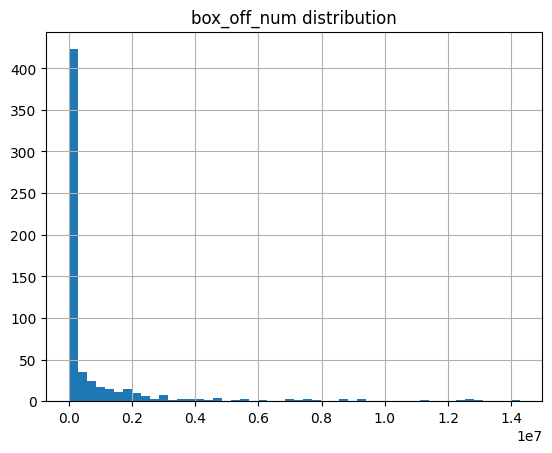

count    6.000000e+02
mean     7.081818e+05
std      1.828006e+06
min      1.000000e+00
25%      1.297250e+03
50%      1.259100e+04
75%      4.798868e+05
max      1.426277e+07
Name: box_off_num, dtype: float64


In [85]:
import matplotlib.pyplot as plt

plt.figure()
train["box_off_num"].hist(bins=50)
plt.title("box_off_num distribution")
plt.show()

print(train["box_off_num"].describe())

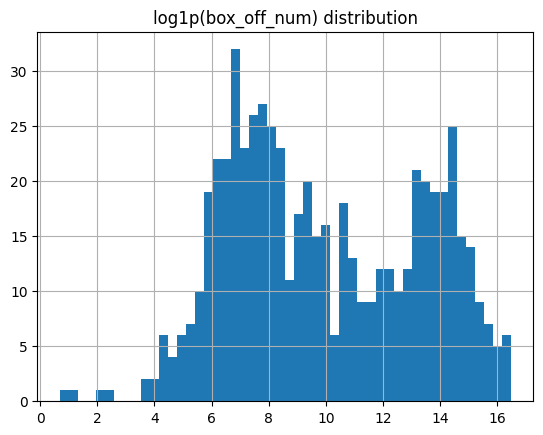

In [86]:
plt.figure()
np.log1p(train["box_off_num"]).hist(bins=50)    #log1p는 자연로그 +1을 의미, 관객수가 0일수 있으니까 0이라도 분포 볼수 있게 사용, bins는 막대 개수
plt.title("log1p(box_off_num) distribution")
plt.show()

## 결측치 채우기

In [87]:
# X, y 먼저 만들기
target = "box_off_num"
X = train.drop(columns=[target]).copy()
y = train[target].copy()
X_test = test.copy()

# 결측 플래그 + 0 채움
X["dir_prev_missing"] = X["dir_prev_bfnum"].isna().astype(int)             #이전 관객이 실제 없는 사례와 구분 위해 새로운 행 만듦
X_test["dir_prev_missing"] = X_test["dir_prev_bfnum"].isna().astype(int)   #isna가 결측이면 1, 아니면 0 넣게됨

X["dir_prev_bfnum"] = X["dir_prev_bfnum"].fillna(0)                        #원래 결측값에 0넣기
X_test["dir_prev_bfnum"] = X_test["dir_prev_bfnum"].fillna(0)


## 피처 상관관계 확인

In [88]:
tmp = X.copy()
tmp["y_log"] = np.log1p(y)
corr = tmp.select_dtypes(include=["number"]).corr()["y_log"].sort_values(ascending=False)
corr.head(20)


y_log               1.000000
num_staff           0.745085
time                0.597995
dir_prev_num        0.404625
dir_prev_bfnum      0.293076
num_actor           0.111407
dir_prev_missing   -0.377437
Name: y_log, dtype: float64

# 전처리

In [89]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

len(num_cols), len(cat_cols), cat_cols[:10]

(6,
 6,
 ['title',
  'distributor',
  'genre',
  'release_time',
  'screening_rat',
  'director'])

## OHE전 데이터 솎아내기

In [90]:
train["release_time"] = pd.to_datetime(train["release_time"], errors="coerce")
test["release_time"]  = pd.to_datetime(test["release_time"],  errors="coerce")

for df in (train, test):
    df["release_year"] = df["release_time"].dt.year                             #연도 영향성 확인 열
    df["release_month"] = df["release_time"].dt.month                           #월 영향성 확인 열
    df["release_dow"] = df["release_time"].dt.dayofweek                         #주중 영향성 확인 열(개봉일 몰리는 요일 등)
    df["release_quarter"] = df["release_time"].dt.quarter                       #계절성 영향성 확인 열
    df["release_is_weekend"] = df["release_dow"].isin([5, 6]).astype(int)       #주말 영향성 확인 열

# ✅ 여기서 먼저 결측률 확인
print(train[["release_year","release_month","release_dow","release_quarter","release_is_weekend"]].isna().mean())

# ✅ 확인 끝나면 drop
train = train.drop(columns=["release_time"])
test  = test.drop(columns=["release_time"])


release_year          0.0
release_month         0.0
release_dow           0.0
release_quarter       0.0
release_is_weekend    0.0
dtype: float64


In [91]:
drop_cols = [c for c in ["title", "director"] if c in X.columns]            #너무 고유 요소인 제목과 감독 drop(감독은 이전작 관객수가 대신)
X = X.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()


# 베이스라인 모델

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor

preprocess = ColumnTransformer(
    transformers=[                                                      #안에 규칙 여러개 넣기
        ("num", Pipeline([                                              #숫자 전처리
            ("imputer", SimpleImputer(strategy="median"))               #중앙값으로 결측처리
        ]), num_cols),
        ("cat", Pipeline([                                              #문자 전처리
            ("imputer", SimpleImputer(strategy="most_frequent")),       #최빈값으로 결측처리
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))          #문자 종류별로 줄세워서 매기기, ignore는 학습때 없던 장르가 나와도 에러 안나고 무시하게 함
        ]), cat_cols),
    ],
    remainder="drop"
)

model = HistGradientBoostingRegressor(random_state=42)

pipe = Pipeline([
    ("prep", preprocess),
    ("model", model)
])


In [93]:
pipe.fit(X, y)

pred = pipe.predict(X_test)
pred = np.maximum(pred, 0)

In [94]:
from sklearn.model_selection import KFold
from sklearn.base import clone
import numpy as np

cv = KFold(n_splits=5, shuffle=True, random_state=42)

fold_rmse = []
oof_pred = np.zeros(len(X))

for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    
    m = clone(pipe)
    m.fit(X_tr, y_tr)
    pred_va = m.predict(X_va)
    oof_pred[va_idx] = pred_va
    
    rmse = np.sqrt(np.mean((y_va - pred_va) ** 2))
    fold_rmse.append(rmse)
    print(f"Fold {fold} RMSE: {rmse:.2f}")

fold_rmse = np.array(fold_rmse)
print("RMSE mean:", fold_rmse.mean())
print("RMSE std :", fold_rmse.std())

# 전체 OOF RMSE(참고)
oof_rmse = np.sqrt(np.mean((y - oof_pred) ** 2))
print("OOF RMSE (all):", oof_rmse)


Fold 1 RMSE: 1373534.99
Fold 2 RMSE: 1164309.30
Fold 3 RMSE: 1529318.04
Fold 4 RMSE: 1642125.63
Fold 5 RMSE: 1756910.25
RMSE mean: 1493239.6403657664
RMSE std : 207612.7417202514
OOF RMSE (all): 1507603.2880317962


## 모델별 비교(5가지)

### sparse 전처리

In [95]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))  # 기본: sparse
        ]), cat_cols),
    ]
)


### dense 전처리

In [96]:
preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ]
)


In [97]:
from sklearn.linear_model import Ridge, ElasticNet, SGDRegressor

models_sparse = {
    "Ridge": Ridge(),                                                           #릿지 회귀 (선형 + 과적합 방지)
    "ElasticNet": ElasticNet(random_state=42),                                  #릿지 + lasso
    "SGDRegressor": SGDRegressor(random_state=42, max_iter=5000, tol=1e-3)      #확률적 경사하강 선형회귀
}

In [98]:
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

models_dense = {    
    "HistGB": HistGradientBoostingRegressor(random_state=42),                               #트리기반 비선형/상호작용
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)     #랜덤 포레스트
}


In [99]:
from sklearn.model_selection import KFold, cross_val_score

def eval_models(models, preprocess, X, y, cv):
    results = []
    for name, model in models.items():
        pipe = Pipeline([("prep", preprocess), ("model", model)])
        rmse = -cross_val_score(pipe, X, y, cv=cv, scoring="neg_root_mean_squared_error")
        results.append({
            "model": name,
            "rmse_mean": rmse.mean(),
            "rmse_std": rmse.std(),
            "fold_rmse": np.round(rmse, 2)
        })
    return pd.DataFrame(results).sort_values("rmse_mean")

df_sparse = eval_models(models_sparse, preprocess_sparse, X, y, cv)
df_dense  = eval_models(models_dense,  preprocess_dense,  X, y, cv)

print("=== Sparse models (lower is better) ===")
display(df_sparse)

print("=== Dense models (lower is better) ===")
display(df_dense)

=== Sparse models (lower is better) ===


,model,rmse_mean,rmse_std,fold_rmse
1,ElasticNet,1.489882e+06,2.983702e+05,"[1182850.91, 1083777.11, 1624918.64, 1761615.4..."
0,Ridge,1.511563e+06,2.905493e+05,"[1245448.4, 1086740.35, 1660008.5, 1811255.12,..."
2,SGDRegressor,2.032521e+21,2.053587e+21,"[8.895192228544271e+20, 1.1643702444214418e+21..."


=== Dense models (lower is better) ===


,model,rmse_mean,rmse_std,fold_rmse
1,RandomForest,1.476702e+06,316208.953098,"[1144846.03, 1081217.05, 1524899.61, 1831472.8..."
0,HistGB,1.493240e+06,207612.741720,"[1373534.99, 1164309.3, 1529318.04, 1642125.63..."


# 제출

In [100]:
import numpy as np

# 템플릿의 타깃 컬럼명 찾기 (title 제외한 나머지 1개)
target_col = [c for c in sub_tmpl.columns if c != "title"][0]

sub_out = sub_tmpl.copy()

# title이 템플릿과 test가 같은 순서라고 가정하면, 그냥 예측만 넣으면 끝
sub_out[target_col] = np.maximum(pred_enet, 0)

sub_out.to_csv("submission.csv", index=False)
sub_out.head()

,title,box_off_num
0,용서는 없다,1.659372e+06
1,아빠가 여자를 좋아해,1.439361e+06
2,하모니,2.754775e+06
3,의형제,2.241194e+06
4,평행 이론,1.827283e+06
